In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import scipy.stats
%matplotlib inline

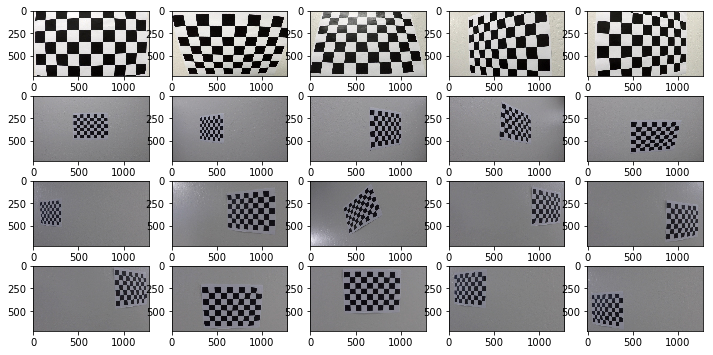

In [2]:
plt.figure(figsize=(12,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    img = plt.imread('camera_cal/calibration{}.jpg'.format(i+1))
    plt.imshow(img)
    plt.savefig('output_images/calibration_images.jpg', bbox_inches='tight')

In [3]:
def undistort(img, nx=9, ny=6):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    op = []
    ip = []
    if ret:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        ip.append(corners)
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        op.append(objp)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(op, ip, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

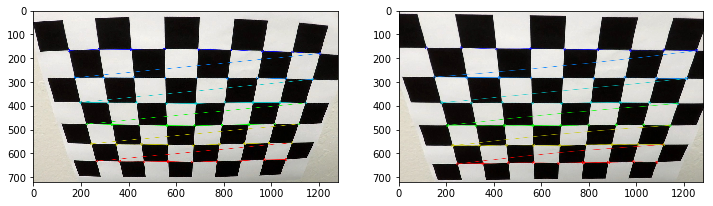

In [4]:
img = plt.imread('camera_cal/calibration2.jpg')
undist = undistort(img)
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(img)
ax[1].imshow(undist)
plt.savefig('output_images/undistorted_chess.jpg', bbox_inches='tight')

In [5]:
def undistortAll(nx=9, ny=6, debug=False):
    fnames = glob.glob('camera_cal/calibration*.jpg')
    objpoints = []
    imgpoints = []
    shape = []
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for fname in fnames:
        img = plt.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        shape = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.figure()
            #plt.imshow(img)
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    if debug:
        for fname in fnames:
            img = plt.imread(fname)
            dst = cv2.undistort(img, mtx, dist, None, mtx)
            plt.figure(figsize=(8,4))
            plt.subplot(2,2,1)
            plt.imshow(img)
            plt.subplot(2,2,2)
            plt.imshow(dst)
            
    return mtx, dist

def getMat():
    src = np.float32([[284,672], [603,444], [678,444 ], [1035,675]])
    dst = np.float32([[400,720], [400,0], [880,0], [880,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

In [6]:
mtx, dist = undistortAll(debug=False)
M, Minv = getMat()

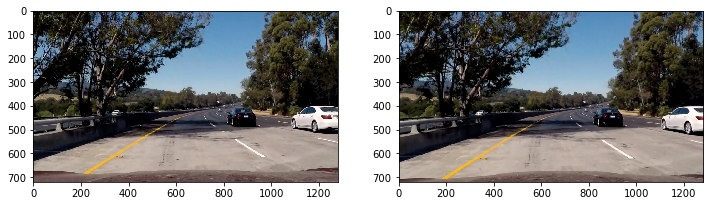

In [7]:
img = plt.imread('test_images/test5.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(img)
ax[1].imshow(undist)
plt.savefig('output_images/undistorted_camera.jpg', bbox_inches='tight')

In [8]:
def thres(img, s_thresh=(170, 255), sx_thresh=(80, 130), h_thresh=(0,180)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    hcombined_binary = np.zeros_like(sxbinary)
    hcombined_binary[(h_binary == 1) & ((s_binary == 1) | (sxbinary == 1))] = 1

    return hcombined_binary

def transform(img, M):
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

def getWarped(img, mtx, dist, M):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = thres(undist)
    warped = transform(binary, M)
    return warped

def weightedHist(hist):
    xlen = hist.shape[0]
    midx = int(xlen / 2)
    guess_left = 400
    guess_right = xlen - guess_left
    guess_width = guess_left / 2
    normx = range(xlen)
    norm_left = scipy.stats.norm.pdf(normx, guess_left, guess_width)
    norm_left /= np.max(norm_left)
    norm_left[midx:] = 1
    norm_right = scipy.stats.norm.pdf(normx, guess_right, guess_width)
    norm_right /= np.max(norm_right)
    norm_right[:midx] = 1
    h2 = hist * norm_right * norm_left
    return h2

def getCurve(lefty, leftx, righty, rightx, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

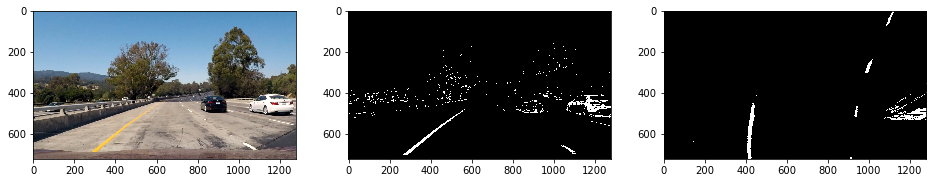

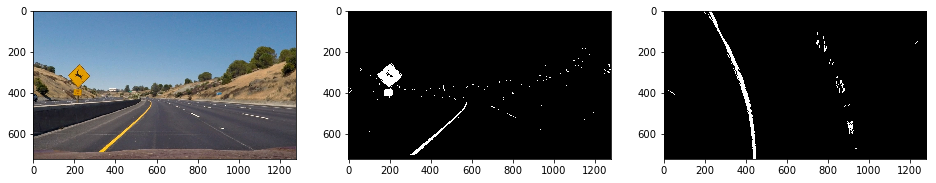

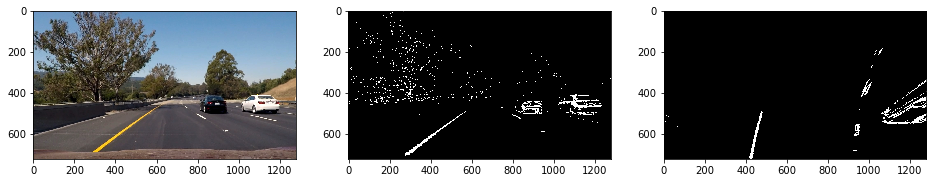

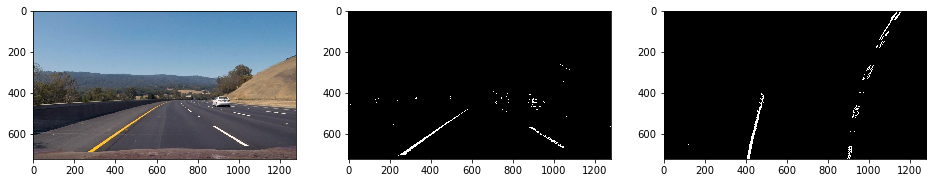

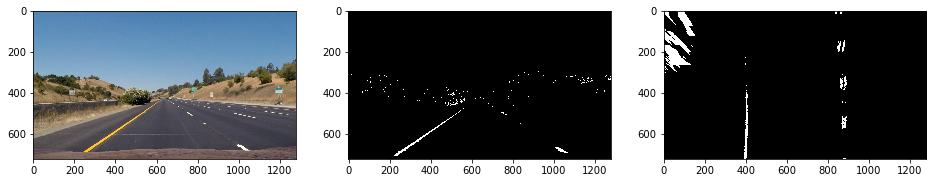

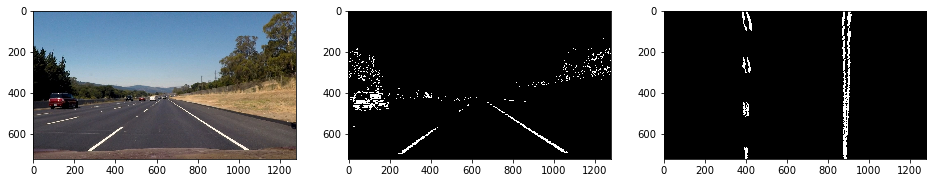

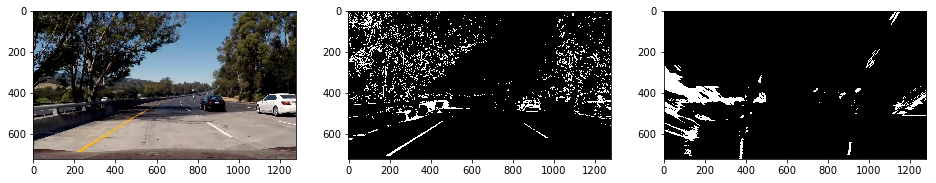

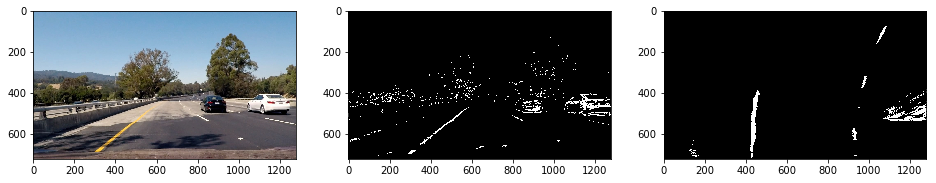

In [9]:
fnames = glob.glob('test_images/*.jpg')
for i, fname in enumerate(fnames):
    img = plt.imread(fname)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = thres(undist)
    warped = transform(binary, M)

    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(binary, cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(warped, cmap='gray')
    plt.savefig('output_images/test_warped_{}.jpg'.format(i), bbox_inches='tight')

In [10]:

def boxSearch(warped, doPlot=False):
    #binary = thres(img)
    #warped = transform(binary, mtx, dist)
    midx = int(warped.shape[1]/2)
    midy = int(warped.shape[0]/2)
    
    # Take a histogram of the bottom half of the image
    histogram0 = np.sum(warped[midy:,:], axis=0)
    histogram = weightedHist(histogram0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    
    # Find the peak of the left and right halves of the histogram
    leftx_base = np.argmax(histogram[:midx])
    rightx_base = np.argmax(histogram[midx:]) + midx

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if doPlot:
        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1)
        plt.plot(histogram0)

        plt.subplot(1,2,2)
        plt.plot(histogram)
        plt.show()

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Darw the wdindows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If uou found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current  = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curve, right_curve = getCurve(lefty, leftx, righty, rightx, warped.shape[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0] - 1, out_img.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    if doPlot:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.figure(figsize=(8,5))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, 'y-')
        plt.plot(right_fitx, ploty, 'y-')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/box_search.png', bbox_inches='tight')
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx

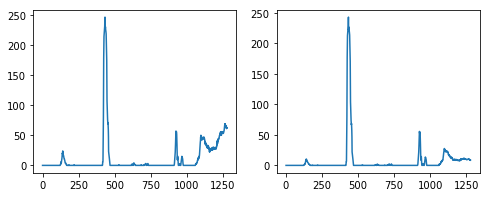

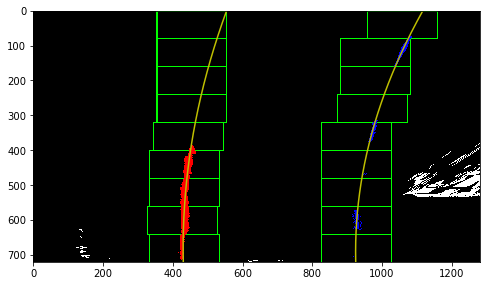

In [11]:
img = plt.imread(fnames[7])
warped = getWarped(img, mtx, dist, M)
left_fit, right_fit, ploty, left_fitx, right_fitx = boxSearch(warped, doPlot=True)

In [12]:
def polySearch(warped, left_fit, right_fit, doPlot=False):
    #binary = thres(img)
    #warped = transform(binary, mtx, dist)

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
    (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
    (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))&
    (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curve, right_curve = getCurve(lefty, leftx, righty, rightx, warped.shape[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if doPlot:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped, warped, warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/poly_search.png', bbox_inches='tight')
        
    return left_fit, right_fit, ploty, left_fitx, right_fitx

In [13]:
def plotLines(img, warped, mtx, dist, ploty, left_fitx, right_fitx):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

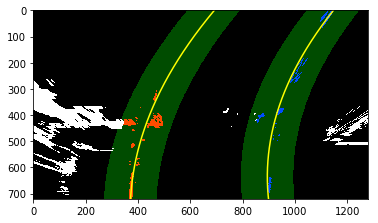

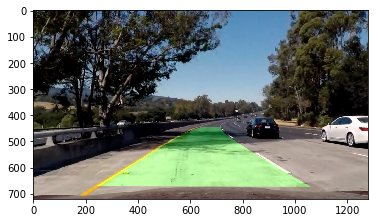

In [14]:
img = plt.imread(fnames[6])
warped = getWarped(img, mtx, dist, M)
left_fit, right_fit, ploty, left_fitx, right_fitx = polySearch(warped, left_fit, right_fit, doPlot=True)

result = plotLines(img, warped, mtx, dist, ploty, left_fitx, right_fitx)
plt.figure()
plt.imshow(result)
plt.savefig('output_images/advanced_lines.jpg', bbox_inches='tight')